In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [21]:
image_size = (128, 128)

In [10]:
def conv_block(X, filters, s=2):
    X_shortcut = X
    f1, f2, f3 = filters
    X = tf.keras.layers.Conv2D(filters=f1, kernel_size=1, padding='valid', strides=(s, s))(X)
    X = tf.keras.layers.BatchNormalization(axis=3)(X)
    X = tf.keras.layers.ReLU()(X)
    
    X = tf.keras.layers.Conv2D(filters=f2, kernel_size=3, padding='same')(X)
    X = tf.keras.layers.BatchNormalization(axis=3)(X)
    X = tf.keras.layers.ReLU()(X)

    X = tf.keras.layers.Conv2D(filters=f3, kernel_size=1, padding='valid')(X)
    X = tf.keras.layers.BatchNormalization(axis=3)(X)
    X = tf.keras.layers.ReLU()(X)
    
    X_shortcut = tf.keras.layers.Conv2D(filters=f3, kernel_size=1, padding='valid', strides=(s,s))(X_shortcut)
    X_shortcut = tf.keras.layers.BatchNormalization(axis=3)(X_shortcut)
    
    X = tf.keras.layers.Add()([X, X_shortcut])
    return tf.keras.layers.ReLU()(X)

In [12]:
def identity_block(X, filters):
    X_shortcut = X
    f1, f2, f3 = filters
    X = tf.keras.layers.Conv2D(filters=f1, kernel_size=1, padding='valid')(X)
    X = tf.keras.layers.BatchNormalization(axis=3)(X)
    X = tf.keras.layers.ReLU()(X)
    
    X = tf.keras.layers.Conv2D(filters=f2, kernel_size=3, padding='same')(X)
    X = tf.keras.layers.BatchNormalization(axis=3)(X)
    X = tf.keras.layers.ReLU()(X)

    X = tf.keras.layers.Conv2D(filters=f3, kernel_size=1, padding='valid')(X)
    X = tf.keras.layers.BatchNormalization(axis=3)(X)
    X = tf.keras.layers.ReLU()(X)
    
    # X_shortcut = tf.keras.layers.Conv2D(filters=f3, kernel_size=1, padding='valid')(X_shortcut)
    # X_shortcut = tf.keras.layers.BatchNormalization(axis=3)(X_shortcut)
    
    X = tf.keras.layers.Add()([X, X_shortcut])
    return tf.keras.layers.ReLU()(X)

In [46]:
def resNet50(input_shape=(128,128,3)):
    X_input = tf.keras.layers.Input(shape=input_shape)
    X = tf.keras.layers.ZeroPadding2D((3,3))(X_input)
    
    X = tf.keras.layers.Conv2D(filters=64, kernel_size=7, strides=2)(X)
    X = tf.keras.layers.BatchNormalization(axis=3)(X)
    X = tf.keras.layers.ReLU()(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=2)(X)
    
    X = conv_block(X, filters=[64, 64, 256], s=1)
    X = identity_block(X, filters=[64, 64, 256])
    X = identity_block(X, filters=[64, 64, 256])

    X = conv_block(X, filters=[128, 128, 512], s=2)
    X = identity_block(X, filters=[128, 128, 512])
    X = identity_block(X, filters=[128, 128, 512])
    X = identity_block(X, filters=[128, 128, 512])

    X = conv_block(X, filters=[256, 256, 1024], s=2)
    X = identity_block(X, filters=[256, 256, 1024])
    X = identity_block(X, filters=[256, 256, 1024])
    X = identity_block(X, filters=[256, 256, 1024])
    X = identity_block(X, filters=[256, 256, 1024])
    X = identity_block(X, filters=[256, 256, 1024])

    X = conv_block(X, filters=[512, 512, 2048], s=2)
    X = identity_block(X, filters=[512, 512, 2048])
    X = identity_block(X, filters=[512, 512, 2048])

    X = tf.keras.layers.AveragePooling2D((2,2), padding='same')(X)
    
    X = tf.keras.layers.Flatten()(X)
    X = tf.keras.layers.Dense(4, activation='softmax')(X)
    
    model = tf.keras.Model(inputs=X_input, outputs=X, name='ResNet50')
    return model

In [22]:
train_data = tf.keras.utils.image_dataset_from_directory('Training/', 
                                                        image_size=image_size,
                                                        validation_split=0.2,
                                                        subset='training',
                                                        shuffle=True,
                                                        seed=10)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.


In [23]:
class_names = train_data.class_names

In [25]:
val_data = tf.keras.utils.image_dataset_from_directory('Training/',
                                                      image_size=image_size,
                                                      validation_split=0.2,
                                                      subset='validation',
                                                      shuffle=True,
                                                      seed=10)

Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


In [26]:
test_data = tf.keras.utils.image_dataset_from_directory('Testing/',
                                                       image_size=image_size,
                                                       batch_size=32,
                                                       shuffle=False,
                                                       seed=10)

Found 1311 files belonging to 4 classes.


In [27]:
rescale_fn = tf.keras.layers.Rescaling(scale=1./255)

train_data = train_data.map(lambda x, y: (rescale_fn(x), y))
val_data = val_data.map(lambda x, y: (rescale_fn(x), y))
test_data = test_data.map(lambda x, y: (rescale_fn(x), y))

In [47]:
model = resNet50(input_shape=(128, 128, 3))

In [48]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [50]:
history = model.fit(train_data, validation_data=val_data, epochs=20)

Epoch 1/20
143/143 [==============================] - 206s 1s/step - loss: 0.7718 - accuracy: 0.7558 - val_loss: 1.0490 - val_accuracy: 0.5919
Epoch 2/20
143/143 [==============================] - 208s 1s/step - loss: 0.7592 - accuracy: 0.7781 - val_loss: 5.1201 - val_accuracy: 0.6331
Epoch 3/20
143/143 [==============================] - 209s 1s/step - loss: 0.4514 - accuracy: 0.8313 - val_loss: 0.6784 - val_accuracy: 0.7426
Epoch 4/20
143/143 [==============================] - 209s 1s/step - loss: 0.4680 - accuracy: 0.8324 - val_loss: 1.4083 - val_accuracy: 0.4930
Epoch 5/20
143/143 [==============================] - 210s 1s/step - loss: 0.4887 - accuracy: 0.8385 - val_loss: 43.6800 - val_accuracy: 0.5149
Epoch 6/20
143/143 [==============================] - 210s 1s/step - loss: 0.3047 - accuracy: 0.8827 - val_loss: 0.4395 - val_accuracy: 0.8249
Epoch 7/20
143/143 [==============================] - 209s 1s/step - loss: 0.4311 - accuracy: 0.8646 - val_loss: 2292.6743 - val_accuracy: 0.

In [52]:
model.save('saved_models/resnet50_scratch.keras')

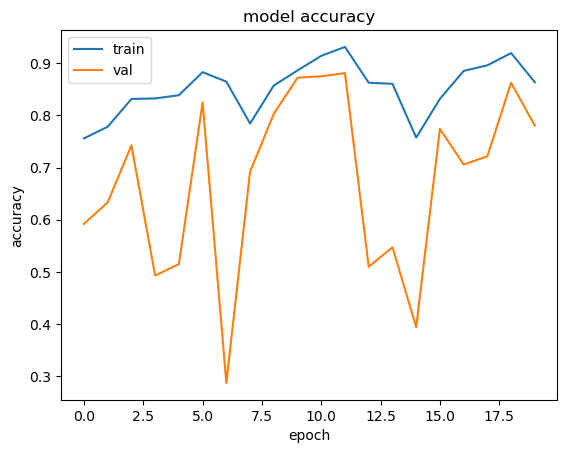

In [53]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

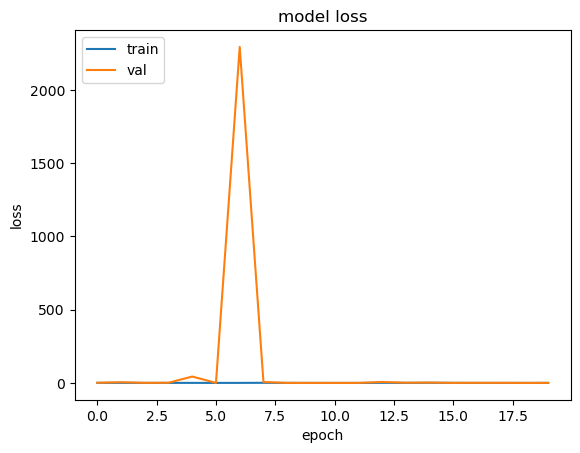

In [54]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [56]:
y_pred = model.predict(test_data)

41/41 [==============================] - 17s 389ms/step


In [57]:
y_pred = tf.argmax(y_pred, axis=1).numpy()

In [58]:
y_true = []
for images, labels in test_data:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

In [59]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay

In [60]:
accuracy_score(y_true, y_pred)

0.7185354691075515

In [61]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[253,  46,   0,   1],
       [ 48, 214,  17,  27],
       [ 37, 127, 199,  42],
       [ 12,  12,   0, 276]], dtype=int64)

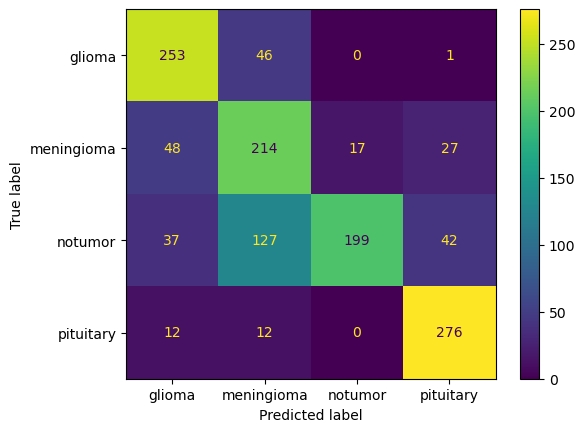

In [62]:
cmd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cmd.plot()
plt.show()

In [63]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      glioma       0.72      0.84      0.78       300
  meningioma       0.54      0.70      0.61       306
     notumor       0.92      0.49      0.64       405
   pituitary       0.80      0.92      0.85       300

    accuracy                           0.72      1311
   macro avg       0.74      0.74      0.72      1311
weighted avg       0.76      0.72      0.71      1311



In [64]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 zero_padding2d_8 (ZeroPadd  (None, 134, 134, 3)          0         ['input_8[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 64, 64)           9472      ['zero_padding2d_8[0][0]']    
                                                                                                  
 batch_normalization_1 (Bat  (None, 64, 64, 64)           256       ['conv2d_1[0][0]']     